# Imports

In [1]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import numpy as np
from matplotlib import pyplot as plt

data_path = "dataset/master_data/"

2022-10-19 20:01:15.247913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 20:01:15.364521: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-19 20:01:15.392095: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-19 20:01:15.997779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Dataset Preparation

In [2]:
# data pipeline utils
data = tf.keras.utils.image_dataset_from_directory(data_path,
                                                   image_size = (512,512),
                                                   color_mode = 'rgb',
                                                   batch_size= 16)

Found 10950 files belonging to 2 classes.


2022-10-19 20:01:18.305458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 20:01:19.998259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22290 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2022-10-19 20:01:19.999418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22290 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-10-19 20:01:20.000376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/t

In [3]:
# Generator to pull batches
data_iterator = data.as_numpy_iterator()

In [4]:
batch = data_iterator.next()

In [5]:
batch[0].shape

(16, 512, 512, 3)

In [6]:
batch[1]
# class 1 = Not Gan Generated
# Class 2 = Gan Generated

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1], dtype=int32)

In [7]:
# Reduce it to [0,1] as we load the data pipeline
# x - images , y - labels
data = data.map(lambda x,y: (x/255,y))

In [8]:
data.as_numpy_iterator().next()

(array([[[[0.02739736, 0.05845205, 0.00492877],
          [0.04054075, 0.07228477, 0.0229473 ],
          [0.0434015 , 0.06597733, 0.01043964],
          ...,
          [0.34901962, 0.5411765 , 0.8117647 ],
          [0.34901962, 0.5411765 , 0.8117647 ],
          [0.34870175, 0.5408586 , 0.81144685]],
 
         [[0.07253753, 0.0952742 , 0.03051471],
          [0.03916207, 0.05696997, 0.01075751],
          [0.05680913, 0.07254902, 0.0070504 ],
          ...,
          [0.34901962, 0.5411765 , 0.8117647 ],
          [0.34901962, 0.5411765 , 0.8117647 ],
          [0.34705883, 0.5392157 , 0.8098039 ]],
 
         [[0.10185739, 0.11754366, 0.06115579],
          [0.04117647, 0.05453048, 0.00540748],
          [0.07630591, 0.09479932, 0.00953585],
          ...,
          [0.35060892, 0.5427658 , 0.813354  ],
          [0.34901962, 0.5411765 , 0.8117647 ],
          [0.34705883, 0.5392157 , 0.8098039 ]],
 
         ...,
 
         [[0.63376606, 0.6455308 , 0.6180798 ],
          [0.61081

# Split the data

In [9]:
len(data) # Num of batches

685

In [10]:
train_size = int(len(data)*.7)  
val_size = int(len(data)*.2) 
test_size = int(len(data)*.1)

In [11]:
print(train_size)
print(val_size)
print(test_size)
print(train_size + val_size + test_size)

479
137
68
684


In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [13]:
print(len(train))
print(len(val))
print(len(test))

479
137
68


# Visualise the images in the batches

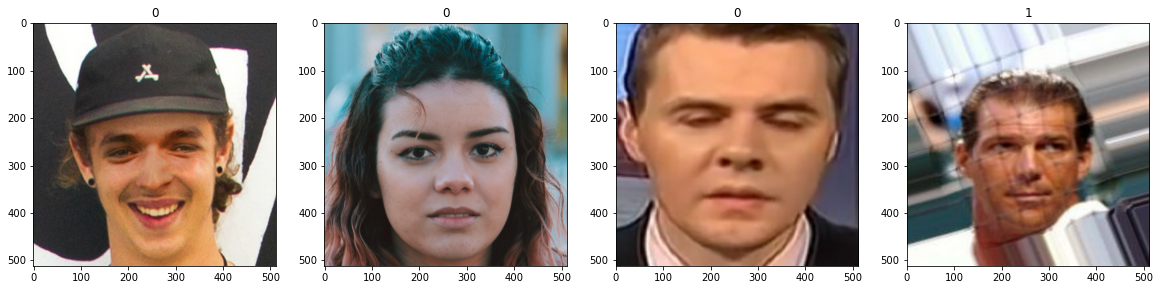

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][8:12]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 0 --> fake
# 1 --> real

# InceptionResnet Model

In [15]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input

inception_model = InceptionResNetV2(include_top = False,
                          weights='imagenet',
                          input_shape = (512,512,3))



In [16]:
model = models.Sequential()
model.add(inception_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 14, 14, 1536)     54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 301056)            0         
                                                                 
 dense (Dense)               (None, 512)               154141184 
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 208,478,946
Trainable params: 208,418,402
Non-trainable params: 60,544
_________________________________________________________________


In [18]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [19]:
# tf.keras.applications.inception_resnet_v2.preprocess_input(data)

In [20]:
hist = model.fit(train, epochs = 20, validation_data = val)

Epoch 1/20


2022-10-19 20:01:41.780230: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-10-19 20:01:42.145663: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-19 20:01:42.148849: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-10-19 20:01:42.148862: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-10-19 20:01:42.148932: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

119/479 [======>.......................] - ETA: 2:14 - loss: 6.0134 - accuracy: 0.7059

2022-10-19 20:02:29.660950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/479 [============>.................] - ETA: 1:37 - loss: 3.4743 - accuracy: 0.7514

2022-10-19 20:03:07.194648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 1.7608 - accuracy: 0.8074

2022-10-19 20:04:50.010313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:04:51.502669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:05:05.864947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 222s 431ms/step - loss: 1.7608 - accuracy: 0.8074 - val_loss: 0.2204 - val_accuracy: 0.8937
Epoch 2/20
119/479 [======>.......................] - ETA: 2:15 - loss: 0.2160 - accuracy: 0.8944

2022-10-19 20:05:56.560127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/479 [============>.................] - ETA: 1:37 - loss: 0.1952 - accuracy: 0.9067

2022-10-19 20:06:34.261990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.1748 - accuracy: 0.9154

2022-10-19 20:08:15.095054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:08:16.606055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:08:30.937477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 205s 428ms/step - loss: 0.1748 - accuracy: 0.9154 - val_loss: 0.1503 - val_accuracy: 0.9229
Epoch 3/20
119/479 [======>.......................] - ETA: 2:15 - loss: 0.1358 - accuracy: 0.9407

2022-10-19 20:09:21.709971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/479 [============>.................] - ETA: 1:38 - loss: 0.1287 - accuracy: 0.9398

2022-10-19 20:09:59.483064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9408

2022-10-19 20:11:40.431540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:11:42.036844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:11:56.338412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 205s 428ms/step - loss: 0.1276 - accuracy: 0.9408 - val_loss: 0.1656 - val_accuracy: 0.9211
Epoch 4/20
119/479 [======>.......................] - ETA: 2:16 - loss: 0.1168 - accuracy: 0.9517

2022-10-19 20:12:47.242539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/479 [============>.................] - ETA: 1:38 - loss: 0.1190 - accuracy: 0.9489

2022-10-19 20:13:25.042579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9370

2022-10-19 20:15:06.169672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:15:07.658969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:15:22.105401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 429ms/step - loss: 0.1969 - accuracy: 0.9370 - val_loss: 2.2868 - val_accuracy: 0.5963
Epoch 5/20
119/479 [======>.......................] - ETA: 2:15 - loss: 0.4624 - accuracy: 0.8619

2022-10-19 20:16:12.981008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/479 [============>.................] - ETA: 1:38 - loss: 0.3345 - accuracy: 0.8847

2022-10-19 20:16:50.778491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.9025

2022-10-19 20:18:31.753628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:18:33.278825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:18:47.635746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 429ms/step - loss: 0.2414 - accuracy: 0.9025 - val_loss: 0.1319 - val_accuracy: 0.9343
Epoch 6/20
119/479 [======>.......................] - ETA: 2:15 - loss: 0.1395 - accuracy: 0.9301

2022-10-19 20:19:38.561649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/479 [============>.................] - ETA: 1:38 - loss: 0.1414 - accuracy: 0.9332

2022-10-19 20:20:16.384541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.9315

2022-10-19 20:21:57.445725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:21:59.027186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:22:13.314346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 429ms/step - loss: 0.1512 - accuracy: 0.9315 - val_loss: 0.1673 - val_accuracy: 0.9156
Epoch 7/20
119/479 [======>.......................] - ETA: 2:15 - loss: 0.1236 - accuracy: 0.9422

2022-10-19 20:23:04.188190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/479 [============>.................] - ETA: 1:38 - loss: 0.1160 - accuracy: 0.9483

2022-10-19 20:23:42.061500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9505

2022-10-19 20:25:23.063521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:25:24.566741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:25:39.049348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 429ms/step - loss: 0.1084 - accuracy: 0.9505 - val_loss: 0.1523 - val_accuracy: 0.9234
Epoch 8/20
121/479 [======>.......................] - ETA: 2:15 - loss: 0.0803 - accuracy: 0.9597

2022-10-19 20:26:30.666278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/479 [============>.................] - ETA: 1:37 - loss: 0.0755 - accuracy: 0.9635

2022-10-19 20:27:08.490101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9576

2022-10-19 20:28:48.726270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:28:50.299456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:29:04.503401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 205s 429ms/step - loss: 0.0977 - accuracy: 0.9576 - val_loss: 0.1415 - val_accuracy: 0.9256
Epoch 9/20
121/479 [======>.......................] - ETA: 2:15 - loss: 0.0986 - accuracy: 0.9551

2022-10-19 20:29:56.198406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/479 [============>.................] - ETA: 1:37 - loss: 0.0856 - accuracy: 0.9615

2022-10-19 20:30:34.017201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.9615

2022-10-19 20:32:14.299492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:32:15.827554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:32:30.090542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 429ms/step - loss: 0.0866 - accuracy: 0.9615 - val_loss: 0.2291 - val_accuracy: 0.9129
Epoch 10/20
121/479 [======>.......................] - ETA: 2:15 - loss: 0.0764 - accuracy: 0.9680

2022-10-19 20:33:21.746783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/479 [============>.................] - ETA: 1:37 - loss: 0.0787 - accuracy: 0.9658

2022-10-19 20:33:59.551440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9657

2022-10-19 20:35:40.005192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:35:41.516599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:35:55.893240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 429ms/step - loss: 0.0829 - accuracy: 0.9657 - val_loss: 0.1646 - val_accuracy: 0.9311
Epoch 11/20
121/479 [======>.......................] - ETA: 2:15 - loss: 0.1152 - accuracy: 0.9540

2022-10-19 20:36:47.562691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/479 [============>.................] - ETA: 1:37 - loss: 0.1017 - accuracy: 0.9581

2022-10-19 20:37:25.392534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9666

2022-10-19 20:39:05.731623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:39:07.231162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:39:21.649482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 429ms/step - loss: 0.0861 - accuracy: 0.9666 - val_loss: 0.4734 - val_accuracy: 0.8882
Epoch 12/20
119/479 [======>.......................] - ETA: 2:16 - loss: 0.0710 - accuracy: 0.9701

2022-10-19 20:40:12.613970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/479 [============>.................] - ETA: 1:38 - loss: 0.0769 - accuracy: 0.9663

2022-10-19 20:40:50.415491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9708

2022-10-19 20:42:31.526736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:42:33.045010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:42:47.449041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 429ms/step - loss: 0.0737 - accuracy: 0.9708 - val_loss: 0.1819 - val_accuracy: 0.9266
Epoch 13/20
121/479 [======>.......................] - ETA: 2:15 - loss: 0.0705 - accuracy: 0.9752

2022-10-19 20:43:39.111823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/479 [============>.................] - ETA: 1:37 - loss: 0.0658 - accuracy: 0.9751

2022-10-19 20:44:16.963966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9753

2022-10-19 20:45:57.282895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:45:58.767397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:46:13.108689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 429ms/step - loss: 0.0629 - accuracy: 0.9753 - val_loss: 0.2242 - val_accuracy: 0.9220
Epoch 14/20
119/479 [======>.......................] - ETA: 2:16 - loss: 0.0691 - accuracy: 0.9753

2022-10-19 20:47:04.025089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/479 [============>.................] - ETA: 1:38 - loss: 0.0730 - accuracy: 0.9723

2022-10-19 20:47:41.851486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9666

2022-10-19 20:49:23.103370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:49:24.694859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:49:39.098059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 430ms/step - loss: 0.0944 - accuracy: 0.9666 - val_loss: 0.1440 - val_accuracy: 0.9220
Epoch 15/20
119/479 [======>.......................] - ETA: 2:16 - loss: 0.0911 - accuracy: 0.9706

2022-10-19 20:50:30.237759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/479 [============>.................] - ETA: 1:38 - loss: 0.0799 - accuracy: 0.9717

2022-10-19 20:51:08.156974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9714

2022-10-19 20:52:49.525469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:52:51.052196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:53:05.399869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 430ms/step - loss: 0.0767 - accuracy: 0.9714 - val_loss: 0.2999 - val_accuracy: 0.8969
Epoch 16/20
121/479 [======>.......................] - ETA: 2:15 - loss: 0.1198 - accuracy: 0.9576

2022-10-19 20:53:57.066024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/479 [============>.................] - ETA: 1:37 - loss: 0.1081 - accuracy: 0.9613

2022-10-19 20:54:34.906562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9628

2022-10-19 20:56:15.425467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:56:17.021401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:56:31.314386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 430ms/step - loss: 0.0976 - accuracy: 0.9628 - val_loss: 7.7461 - val_accuracy: 0.7956
Epoch 17/20
121/479 [======>.......................] - ETA: 2:15 - loss: 0.0737 - accuracy: 0.9731

2022-10-19 20:57:23.085443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/479 [============>.................] - ETA: 1:37 - loss: 0.0712 - accuracy: 0.9714

2022-10-19 20:58:00.916576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9683

2022-10-19 20:59:41.362624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:59:42.917543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 20:59:57.212574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 429ms/step - loss: 0.0789 - accuracy: 0.9683 - val_loss: 0.3564 - val_accuracy: 0.8992
Epoch 18/20
121/479 [======>.......................] - ETA: 2:15 - loss: 0.1128 - accuracy: 0.9597

2022-10-19 21:00:48.846257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/479 [============>.................] - ETA: 1:37 - loss: 0.0872 - accuracy: 0.9678

2022-10-19 21:01:26.636036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9682

2022-10-19 21:03:06.972906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 21:03:08.523817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 21:03:22.817215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 429ms/step - loss: 0.0800 - accuracy: 0.9682 - val_loss: 1.5985 - val_accuracy: 0.8444
Epoch 19/20
119/479 [======>.......................] - ETA: 2:15 - loss: 0.1525 - accuracy: 0.9412

2022-10-19 21:04:13.717498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/479 [============>.................] - ETA: 1:38 - loss: 0.1279 - accuracy: 0.9489

2022-10-19 21:04:51.539635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9592

2022-10-19 21:06:32.619871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 21:06:34.200219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 21:06:48.455497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 429ms/step - loss: 0.1041 - accuracy: 0.9592 - val_loss: 0.1906 - val_accuracy: 0.9252
Epoch 20/20
121/479 [======>.......................] - ETA: 2:15 - loss: 0.0700 - accuracy: 0.9716

2022-10-19 21:07:40.119012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/479 [============>.................] - ETA: 1:37 - loss: 0.0691 - accuracy: 0.9714

2022-10-19 21:08:17.949342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9710

2022-10-19 21:09:58.329049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 21:09:59.872340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-19 21:10:14.206783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


479/479 [==============================] - 206s 429ms/step - loss: 0.0724 - accuracy: 0.9710 - val_loss: 0.1973 - val_accuracy: 0.9170


# PlotPerformance

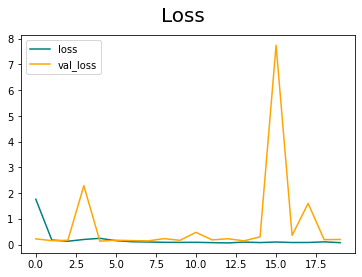

In [21]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal' ,label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange' ,label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

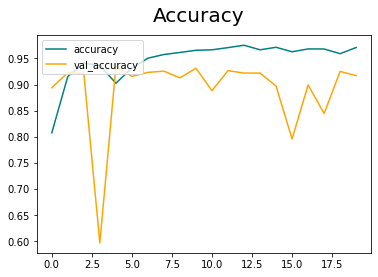

In [22]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange' ,label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

## Saving

In [25]:
# h5 format
import os
save_dir = "checkpoints"

model.save(os.path.join(save_dir, 'inceptionresnetv2_20epochs.h5'))

# SavedModel format
model.save(os.path.join(save_dir, "inceptionresnetv2_20epochs", "model"))

In [29]:
# weights only

model.save_weights(os.path.join(save_dir, "weights/20epochs"))


In [30]:
model.evaluate(test)

2022-10-20 02:31:46.132750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-20 02:31:47.617369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-20 02:31:53.146918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/68 [==============================] - 18s 122ms/step - loss: 0.2116 - accuracy: 0.9081


[0.21160584688186646, 0.908088207244873]

In [2]:
new_model = tf.keras.models.load_model("checkpoints/inceptionresnetv2_20epochs/")

In [33]:
new_model.evaluate(test)

2022-10-20 03:06:58.794657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-20 03:07:00.297361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-20 03:07:05.929878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/68 [==============================] - 19s 130ms/step - loss: 0.2180 - accuracy: 0.9099


[0.2179793119430542, 0.9099264740943909]

In [51]:
import cv2

img = cv2.imread("dataset/master_data/fake/fake_animal_1.png")


img.shape
img = cv2.resize(img, (512,512))
sample = img.reshape(1,512,512,3)
prob = new_model.predict(sample)
print(prob)
if prob[0][0] > prob[0][1]:
    print('Fake')
else:
    print('Real')

1/1 [==============================] - 0s 48ms/step
[[3.3970088e-10 1.0000000e+00]]
Real


### TFLite Conversion

In [1]:
import tensorflow as tf

saved_model_dir = "checkpoints/inceptionresnetv2_20epochs/"

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('InceptionResnetV2_20e.tflite', 'wb') as f:
  f.write(tflite_model)

2022-10-26 15:05:57.579626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 15:06:01.948388: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-26 15:06:03.328068: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-26 15:06:17.233897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [71]:
# test = tf.keras.models.load_model("checkpoints/inceptionresnetv2_20epochs/")

img = cv2.imread("dataset/master_data/fake/fake_face_640.png")

img = cv2.resize(img, (512,512))
sample = img.reshape(1,512,512,3)
prob = test.predict(sample)
prob

# 0 -- > fake, 1 --> real

1/1 [==============================] - 0s 48ms/step


array([[1.1979683e-04, 9.9988019e-01]], dtype=float32)

In [72]:
img_list = os.listdir("dataset/master_data/fake")
dir = "dataset/master_data/fake"

count = 0


for (i, f) in enumerate(img_list):
    img = cv2.imread(os.path.join(dir, f))
    img = cv2.resize(img, (512,512))
    sample = img.reshape(1,512,512,3)
    prob = test.predict(sample)

    if prob[0][0] > prob[0][1]:
        count += 1
    print(count / (i+1))

1/1 [==============================] - 0s 58ms/step
0.0
1/1 [==============================] - 0s 50ms/step
0.0
1/1 [==============================] - 0s 49ms/step
0.0
1/1 [==============================] - 0s 48ms/step
0.25
1/1 [==============================] - 0s 58ms/step
0.4
1/1 [==============================] - 0s 59ms/step
0.3333333333333333
1/1 [==============================] - 0s 55ms/step
0.2857142857142857
1/1 [==============================] - 0s 58ms/step
0.375
1/1 [==============================] - 0s 57ms/step
0.4444444444444444
1/1 [==============================] - 0s 54ms/step
0.4
1/1 [==============================] - 0s 46ms/step
0.36363636363636365
1/1 [==============================] - 0s 40ms/step
0.3333333333333333
1/1 [==============================] - 0s 41ms/step
0.3076923076923077
1/1 [==============================] - 0s 49ms/step
0.35714285714285715
1/1 [==============================] - 0s 52ms/step
0.3333333333333333
1/1 [==============================

KeyboardInterrupt: 